<a href="https://colab.research.google.com/github/AllanKamimura/xmobots/blob/main/predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# init

In [1]:
!git clone https://github.com/AllanKamimura/xmobots.git
!git clone https://github.com/AllanKamimura/utils.git

Cloning into 'xmobots'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 23 (delta 6), reused 14 (delta 3), pack-reused 0
Unpacking objects: 100% (23/23), 18.72 MiB | 8.64 MiB/s, done.
Cloning into 'utils'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 6 (delta 1), reused 6 (delta 1), pack-reused 0
Unpacking objects: 100% (6/6), 1.66 KiB | 1.66 MiB/s, done.


In [2]:
!pip install -q tensorflow-addons

from utils.myutils import *
import tensorflow as tf
import tensorflow_addons as tfa
from tqdm import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 10.6 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [8]:
model = tf.keras.models.load_model("/content/xmobots/saves/mobile_average.h5")
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobile_average (Functional)  (None, 576)              939120    
                                                                 
 my_dense (Sequential)       (None, 2)                 463490    
                                                                 
Total params: 1,402,610
Trainable params: 1,388,706
Non-trainable params: 13,904
_________________________________________________________________


1/1 [==============================] - 0s 35ms/step
tree


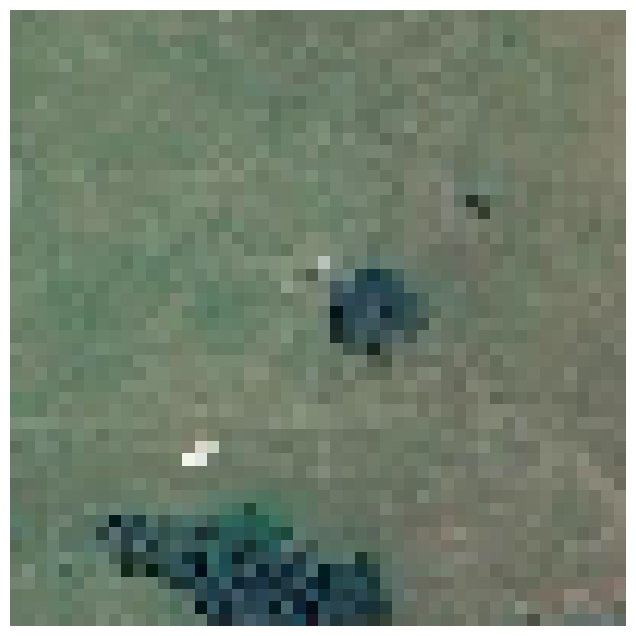

In [14]:
image = tf.keras.preprocessing.image.load_img(
    "/content/xmobots/test.jpg",
    target_size = (50, 50)
)
y_pred = model.predict(tf.expand_dims(image, axis = 0))

plt.imshow(image)
plt.axis("off")

if y_pred[:,1] > 0.57:
    print("tree")
else:
    print("soil")

# **PREDICT**

In [69]:
def predict(folder_path):
    file_list = glob(folder_path + "/*.jpg") + glob(folder_path + "/*.png")
    file_list.sort()
    df = pd.DataFrame({"path": file_list})

    classification = []

    for image_paths in df.rolling(window = 255, closed = "both", step = 256):
        images = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(image_path,target_size = (50, 50))) for image_path in image_paths.path]
        
        y_preds = model.predict(tf.convert_to_tensor(images))
        y_preds = (y_preds[:,1] > 0.57)

        batch_class = ["tree" if y_pred else "soil" for y_pred in y_preds]
        classification.extend(batch_class)

    last_batch = df.iloc[((df.shape[0] // 256) * 256) + 1:]
    images = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(image_path,target_size = (50, 50))) for image_path in last_batch.path]

    y_preds = model.predict(tf.convert_to_tensor(images))
    y_preds = (y_preds[:,1] > 0.57)

    batch_class = ["tree" if y_pred else "soil" for y_pred in y_preds]
    classification.extend(batch_class)

    df["classification"] = classification
    df.to_csv("predict.csv", index = False)

In [70]:
folder_path = "Data" # folder path is the path to the folder
predict(folder_path)

1/1 [==============================] - 0s 54ms/step


# Bonus

1/1 [==============================] - 2s 2s/step


(-0.5, 255.5, 255.5, -0.5)

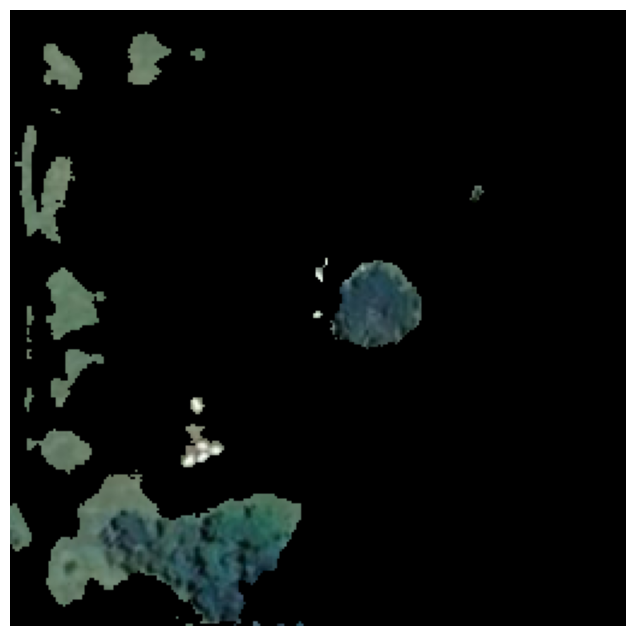

In [95]:
# image segmentation model
unet_model = tf.keras.models.load_model("/content/xmobots/saves/unet_model.h5")
image = tf.keras.preprocessing.image.load_img(
            "/content/xmobots/test.jpg",
            target_size = (256,256)
        )

image = tf.keras.preprocessing.image.img_to_array(image).astype("uint8")
predicts = unet_model.predict(tf.expand_dims(image / 255., axis = 0))
predicts_arg = tf.argmax(predicts, axis = -1)
plt.imshow(image * (np.moveaxis(predicts_arg.numpy(), 0, 2) != 2), cmap = "viridis")
plt.axis("off")

In [4]:
!pip install -q ultralytics

from ultralytics import YOLO
model = YOLO("/content/xmobots/saves/object_detection.pt")
results = model("/content/xmobots/test.jpg")  # predict on an image


image 1/1 /content/xmobots/test.jpg: 640x640 1 1, 881.4ms
Speed: 43.1ms preprocess, 881.4ms inference, 28.1ms postprocess per image at shape (1, 3, 640, 640)


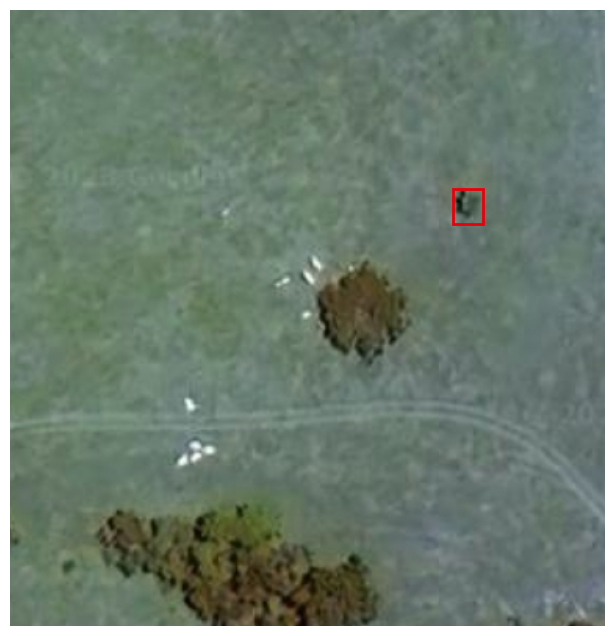

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(results[0].orig_img)

for box in results[0].boxes.xyxy:
    box = box.cpu()
    # Create a Rectangle patch
    rect = patches.Rectangle((box[0], box[1]), abs(box[0]-box[2]), abs(box[1]-box[3]), linewidth=2, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.axis("off")
plt.show()